In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

from scipy.fftpack import fft,fftshift,ifft

In [ ]:
z = 20
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [ ]:
class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)

            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1

            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)

            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

def find_bouts(fly):
    expt_len = 1000*30*60
    resolution = 10
    high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

    behavior = 'Yh'

    B_THRESHOLD = np.std(flies[fly].fictrac.fictrac[behavior])/4
    ALIVE_TIME = 1000 # in ms
    DEAD_TIME = 1000 # in ms

    state = 'quiescent'
    up_streak = 0
    down_streak = 0
    BOUTS = []
    ALIVE_TIME = int(ALIVE_TIME/resolution)
    DEAD_TIME = int(DEAD_TIME/resolution)

    for i in range(len(flies[fly].fictrac.fictrac[behavior])):
        # If high behavior, reset down_streak, and add 1 to up_streak
        if flies[fly].fictrac.fictrac[behavior][i] > B_THRESHOLD:
            down_streak = 0
            up_streak += 1
        else:
            up_streak = 0
            down_streak += 1

        if state == 'quiescent':
            if up_streak >= ALIVE_TIME:
                state = 'moving'
                BOUTS.append({'start': i-ALIVE_TIME})
        elif state == 'moving':
            if down_streak >= DEAD_TIME:
                state = 'quiescent'
                BOUTS[-1]['end'] = i-DEAD_TIME
    BOUTS = [bout for bout in BOUTS if 'end' in bout]
    #print('Found {} bouts'.format(len(BOUTS)))

    ### Clean Start Bouts
    # remove bouts that have behavior too close *before* them
    before = 1000 # in ms
    before = int(before/10)
    start_bouts=[bout for bout in BOUTS if np.mean(np.abs(flies[fly].fictrac.fictrac[behavior][bout['start']-before:bout['start']])) < .2]
    #print('Remaining start_bouts post-cleaning: {}'.format(np.shape(start_bouts)[0]))

    ### Clean Stop Bouts
    # remove bouts that have behavior too close *after* them
    before = 1000 # in ms
    before = int(before/10)
    stop_bouts=[bout for bout in BOUTS if np.mean(np.abs(flies[fly].fictrac.fictrac[behavior][bout['end']:bout['end']+before])) < .2]
    #print('Remaining stop_bouts bouts post-cleaning: {}'.format(np.shape(stop_bouts)[0]))
    return start_bouts, stop_bouts

def bout_triggered(fly, neural_data, all_bouts, bout_type, original_z):
    if bout_type == 'start_bouts':
        align_to = 'start'
    elif bout_type == 'stop_bouts':
        align_to = 'end'
    before = 3000 #in ms
    after = 3000 # in ms
    jump = flies[fly].timestamps[1,0]-flies[fly].timestamps[0,0]
    num_neural_points = int(before/jump)

    before = int(before/10) # now everything is in units of 10ms
    after = int(after/10)
    bins = bbb.create_bins(10,before*10,after*10)[:-1]

    xss = []; yss = []
    for i in range(len(all_bouts[bout_type])):
        nearest = np.searchsorted(flies[fly].timestamps[:,original_z]/10, all_bouts[bout_type][i][align_to])
        offset = (flies[fly].timestamps[nearest,original_z]/10 - all_bouts[bout_type][i][align_to])*10
        xs = np.arange(offset-num_neural_points*jump,offset+num_neural_points*jump,jump)
        ys = neural_data[nearest-num_neural_points:nearest+num_neural_points]
        if len(ys) == 10:
            xss.append(xs); yss.append(ys)
    xss = np.asarray(xss); yss = np.asarray(yss)

    sum_bouts = [flies[fly].fictrac.fictrac['Yh'][bout[align_to]-before:bout[align_to]+after] for bout in all_bouts[bout_type]]#[1:-1]
    sum_bouts = np.asarray(sum_bouts)
    #avg_bout = np.mean(sum_bouts,axis=0)

    return xss, yss, sum_bouts

In [ ]:
###################
### Build Flies ###
###################
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac(z)

In [9]:
before = 3000 #in ms
after = 3000 # in ms
before = int(before/10) # now everything is in units of 10ms
after = int(after/10)

In [17]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_temporal.npy'
temporal = np.load(file)
temporal = temporal*-1
temporal.shape #timepoint by PC

(30456, 1000)

In [19]:
fly_num = 2
start = fly_num*3384
end = (fly_num+1)*3384

fly_pcs = temporal[start:end,:3]
fly_pcs.shape

(3384, 3)

In [20]:
#interp PCs
expt_len = 1000*30*60
resolution = 532
x_original = np.arange(0,expt_len,resolution)
interp_object = interp1d(x_original, fly_pcs.T, bounds_error = False)

expt_len = 1000*30*60
x_new = np.arange(0,expt_len,10)
pcs_10hz = interp_object(x_new)
pcs_10hz.shape

(3, 180000)

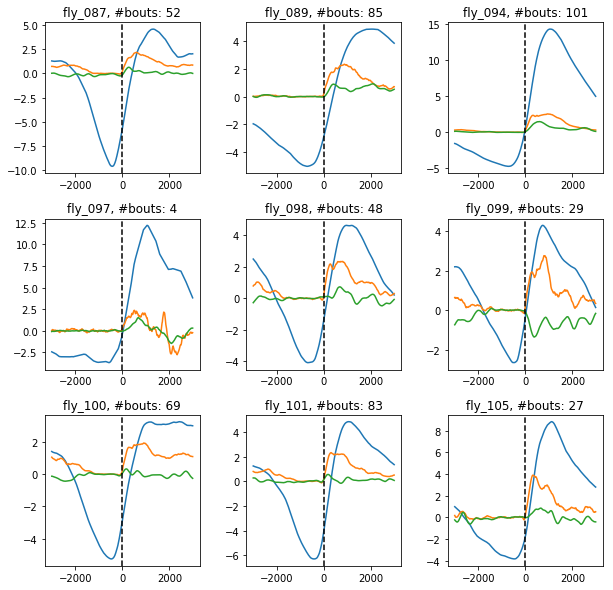

In [33]:
align_to = 'start'
bout_type = 'start_bouts'
#fig = plt.figure(figsize=(10,10))
#grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=.05)
xs = np.arange(-3000,3000,10)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
pooled_bouts = {'fwd_bouts': np.empty((0,600)), 'rot_bouts': np.empty((0,600))}

fly_num = -1
for fly, ax in zip(fly_names,axs.flat):
    start_bouts, stop_bouts = find_bouts(fly)
    all_bouts = {'start_bouts': start_bouts, 'stop_bouts': stop_bouts}
    
    fly_num += 1
    start = fly_num*3384
    end = (fly_num+1)*3384
    fly_pcs = temporal[start:end,:3]
    fly_pcs.shape
    
    #interp PCs
    expt_len = 1000*30*60
    resolution = 532
    x_original = np.arange(0,expt_len,resolution)
    interp_object = interp1d(x_original, fly_pcs.T, bounds_error = False)

    expt_len = 1000*30*60
    x_new = np.arange(0,expt_len,10)
    pcs_100hz = interp_object(x_new)
    
    pc_bouts = [pcs_100hz[0,:][bout[align_to]-before:bout[align_to]+after] for bout in all_bouts[bout_type]]
    pc_bouts = np.mean(pc_bouts,axis=0)
    ax.plot(xs,pc_bouts)
    
    forward_bouts = [flies[fly].fictrac.fictrac['Yh'][bout[align_to]-before:bout[align_to]+after] for bout in all_bouts[bout_type]]#[1:-1]
    forward_bouts = np.asarray(forward_bouts)
    pooled_bouts['fwd_bouts'] = np.vstack((pooled_bouts['fwd_bouts'], forward_bouts))
    num_bouts = forward_bouts.shape[0]
    forward_bouts = np.mean(forward_bouts,axis=0)

    rot_bouts = [flies[fly].fictrac.fictrac['Zh'][bout[align_to]-before:bout[align_to]+after] for bout in all_bouts[bout_type]]#[1:-1]
    rot_bouts = np.asarray(rot_bouts)
    pooled_bouts['rot_bouts'] = np.vstack((pooled_bouts['rot_bouts'], rot_bouts))
    rot_bouts = np.mean(rot_bouts,axis=0)
    
    ax.plot(xs,forward_bouts)
    ax.plot(xs,rot_bouts)
    ax.set_title('{}, #bouts: {}'.format(fly, num_bouts),fontsize=12)
    ax.axvline(0,color='k',linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=10)
    
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [27]:
len(pc_bouts)

27

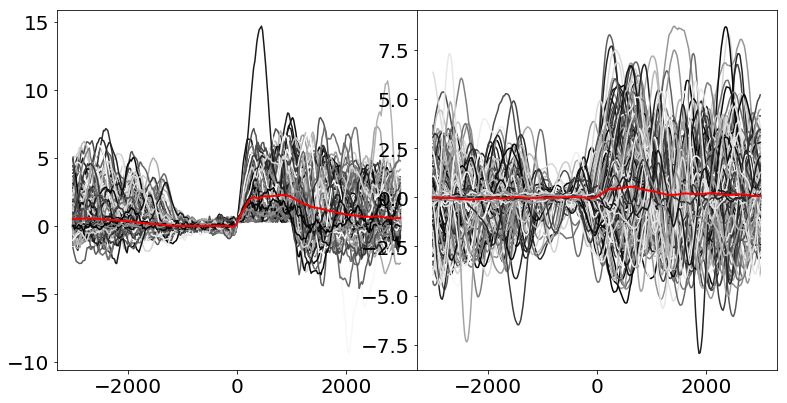

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,.5,.5])
for i in range(498):
    ax.plot(xs, pooled_bouts['fwd_bouts'][i,:],color=str(float(np.random.randint(0,255,1)/255)))
ax.plot(xs, np.mean(pooled_bouts['fwd_bouts'],axis=0),linewidth=2,color='r')

ax = fig.add_axes([.5,0,.5,.5])
for i in range(498):
    ax.plot(xs, pooled_bouts['rot_bouts'][i,:],color=str(float(np.random.randint(0,255,1)/255)))
ax.plot(xs, np.mean(pooled_bouts['rot_bouts'],axis=0),linewidth=2,color='r')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

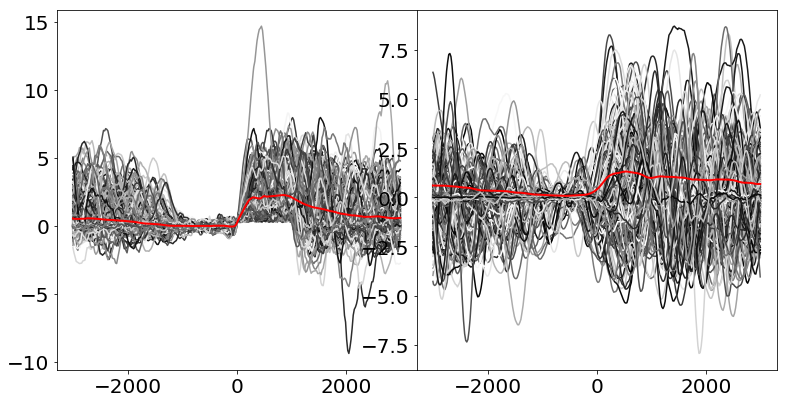

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,.5,.5])
for i in range(498):
    ax.plot(xs, pooled_bouts['fwd_bouts'][i,:],color=str(float(np.random.randint(0,255,1)/255)))
ax.plot(xs, np.mean(pooled_bouts['fwd_bouts'],axis=0),linewidth=2,color='r')

ax = fig.add_axes([.5,0,.5,.5])
for i in range(498):
    ax.plot(xs, pooled_bouts['rot_bouts'][i,:],color=str(float(np.random.randint(0,255,1)/255)))
ax.plot(xs, np.mean(np.abs(pooled_bouts['rot_bouts']),axis=0),linewidth=2,color='r')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [14]:
pooled_bouts['fwd_bouts'].shape

(498, 600)